# Unitary MPO check

Created 26/08/2024

Objectives:
* Investigate w tensors of mpo's. Check what unitarity implies.

# Package imports

In [1]:
import sys

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce
from operator import mul

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    multiply_transfer_matrices
)

from SPTOptimization.Optimizers.utils import (
    one_site_optimization_sweep_right
)

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"data/transverse_cluster_200_site_dmrg"

In [8]:
f_name = DATA_DIR + r"/0_90.h5"

In [9]:
f_name

'data/transverse_cluster_200_site_dmrg/0_90.h5'

In [10]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [11]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM

SVD_CUTOFF = 1e-3

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [14]:
test = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    [np_X, np_I]*50
)

In [15]:
test.compute_svd_symmetry_action()

In [16]:
test.right_projected_symmetry_state

<npc.Array shape=(8, 8) labels=['vR', 'vR*']>

In [17]:
test.left_projected_symmetry_state

<npc.Array shape=(8, 8) labels=['vL', 'vL*']>

In [18]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [19]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

### Leg and label functions

In [20]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [21]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [22]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [23]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [24]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [25]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [26]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [27]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

### Other

In [28]:
def contract_virtual_legs(tl, tr):
    return npc.tensordot(tl, tr, ['vR', 'vL'])

In [29]:
def combine_tensors(tensors):
    out = reduce(contract_virtual_legs, tensors)

    leg_labels = [
        extract_single_physical_leg_label_from_tensor(t)
        for t in tensors
    ]

    out = out.combine_legs(leg_labels)

    return out

In [30]:
def combine_b_tensors(b_tensors):
    renamed_tensors = [
        b.replace_label('p', f'p{i}')
        for i, b in enumerate(b_tensors)
    ]

    return combine_tensors(renamed_tensors)

In [31]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [283]:
def svd_reduce_split_tensor(t, max_inner_dim=MAX_VIRTUAL_BOND_DIM,
                           normalise=True, svd_cutoff=SVD_CUTOFF):
    U, S, VH = npc.svd(
        t,
        compute_uv=True,
        inner_labels=['vR', 'vL'],
        cutoff=svd_cutoff
    )

    # Truncate tensors:
    U = U[:, :max_inner_dim]
    S = S[:max_inner_dim]
    VH = VH[:max_inner_dim, :]

    if normalise:
        new_norm = np.sqrt(np.sum(S**2))
        S = S/new_norm

    """
    leg = VH.get_leg('vL')

    schmidt_values = npc.diag(S, leg, labels=['vL', 'vR'])
    """

    return U, S, VH

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [33]:
def split_combined_b(b, leftmost_schmidt_values,
                     max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = b.split_legs()

    num_sites = t.ndim - 2

    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    out_bs = list()
    out_schmidt_values = list()

    current_left_schmidt_values = leftmost_schmidt_values

    for i, ll in enumerate(p_leg_labels[:-1]):
        t.iscale_axis(current_left_schmidt_values, axis='vL')

        tail_legs = p_leg_labels[(i+1):]
        
        t = t.combine_legs([['vL', ll], ['vR', *tail_legs]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=True
        )

        bl = (
            U
            .split_legs()
            .replace_label(ll, 'p')
        )
        bl.iscale_axis(1/current_left_schmidt_values, axis='vL')
        bl.iscale_axis(S, axis='vR')
        bl.itranspose(['vL', 'p', 'vR'])
        out_bs.append(bl)

        out_schmidt_values.append(S)
        current_left_schmidt_values=S

        t = VH.split_legs()

    bl = t.replace_label(p_leg_labels[-1], 'p')
    bl.itranspose(['vL', 'p', 'vR'])
    out_bs.append(bl)

    return out_bs, out_schmidt_values

In [34]:
def split_b(b, max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    leg_label = get_physical_leg_labels(b)[0]

    if is_single_physical_leg_label(leg_label):
        return b
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_b(b, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [35]:
def split_combined_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = u.split_legs()
    num_sites = t.ndim //2
    
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    p_leg_labels_hc = [l+'*' for l in p_leg_labels]
    out_ws = list()

    for i, (ll, ll_hc) in enumerate(zip(p_leg_labels[:-1], p_leg_labels_hc[:-1])):
        tail_legs = p_leg_labels[(i+1):]
        tail_legs_hc = p_leg_labels_hc[(i+1):]

        left_leg_labels = [ll, ll_hc]
        if 'vL' in t.get_leg_labels():
            left_leg_labels.append('vL')
    
        t = t.combine_legs([left_leg_labels, [*tail_legs, *tail_legs_hc]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=False
        )

        U.iscale_axis(S, axis='vR')

        wl = U.split_legs().replace_labels([ll, ll_hc], ['p', 'p*'])
        #wl.itranspose(['p', 'p*'])
        out_ws.append(wl)

        t = VH.split_legs()

    wl = t.replace_labels(
        [p_leg_labels[-1], p_leg_labels_hc[-1]],
        ['p', 'p*']
    )
    #wl.itranspose(['p', 'p*'])
    out_ws.append(wl)

    out_ws[0] = (
        out_ws[0]
        .add_leg(left_trivial_leg_charge, 0, label='vL')
    )
    
    out_ws[-1] = (
        out_ws[-1]
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out_ws

In [36]:
def split_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
            p_leg_labels=None):
    leg_label = get_physical_leg_labels(u)[0]

    if is_single_physical_leg_label(leg_label):
        return [unitary_to_mpo_tensor(u),]
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_u(u, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [37]:
def unitary_to_mpo_tensor(u):
    out = (
        u
        .add_leg(left_trivial_leg_charge, 0, label='vL')
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out

In [38]:
def multiply_individual_mpo_tensors(w1, w2):
    w1 = w1.replace_labels(['vR', 'vL'], ['vR1', 'vL1'])
    w2 = w2.replace_labels(['vR', 'vL'], ['vR2', 'vL2'])

    w = (
        npc.tensordot(w1, w2, [['p'], ['p*']])
        .combine_legs([['vR1', 'vR2'], ['vL1', 'vL2']])
        .replace_labels(['(vR1.vR2)', '(vL1.vL2)'], ['vR', 'vL'])
    )

    return w

In [39]:
def group_elements(l, group_size, offset=0):
    first, rest = l[:offset], l[offset:]

    num_rest_groups = ((len(rest)-1)//group_size) + 1

    groups = [first,] if first else list()

    for i in range(num_rest_groups):
        first_index = i*group_size
        last_index = (i+1)*group_size
        groups.append(rest[first_index:last_index])

    return groups

In [40]:
def combine_grouped_b_tensors(grouped_bs):
    out = list()

    for group in grouped_bs:
        if len(group) == 1:
            out.append(group[0])
        else:
            out.append(combine_b_tensors(group))

    return out

In [41]:
def reduce_virtual_mpo_dim(wl, wr, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    # wl = wl.replace_labels(['p', 'p*'], ['pl', 'pl*'])

    wl = wl.combine_legs(['p', 'vL', 'p*'])
    wr = wr.combine_legs(['p', 'vR', 'p*'])
    w = npc.tensordot(wl, wr, ['vR', 'vL'])

    wl, S, wr = svd_reduce_split_tensor(
        w,
        max_inner_dim=max_virtual_bond_dim
    )

    wl.iscale_axis(S, axis='vR')

    wl = wl.split_legs()
    wr = wr.split_legs()

    return wl, wr

In [42]:
def multiply_mpos(top_ws, bottom_ws, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    ws = list()
    
    for w1, w2 in zip(top_ws, bottom_ws):
        w = multiply_individual_mpo_tensors(w1, w2)
        ws.append(w)


    for i in range(len(ws)-1):
        ws[i], ws[i+1] = reduce_virtual_mpo_dim(
            ws[i],
            ws[i+1],
            max_virtual_bond_dim=max_virtual_bond_dim
        )

    return ws

### Layer function

In [43]:
def optimise_layer(
        left_environment,
        top_b_tensors,
        left_schmidt_values,
        block_width,
        block_offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors=None,
        num_iterations=1,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    ):

    if bottom_b_tensors is None:
        bottom_b_tensors = top_b_tensors

    group = lambda x: group_elements(x, block_width, block_offset)
    top_grouped_bs = group(top_b_tensors)
    bottom_grouped_bs = group(bottom_b_tensors)
    grouped_schmidt_values = group(left_schmidt_values)

    top_combined_bs = combine_grouped_b_tensors(top_grouped_bs)
    bottom_combined_bs = combine_grouped_b_tensors(bottom_grouped_bs)

    unitaries = [
        get_identity_operator(t) for t in top_combined_bs
    ]

    expectations.append(list())

    for _ in range(num_iterations):
        exps, *_ = one_site_optimization_sweep_right(
            left_environment,
            top_combined_bs,
            unitaries,
            bottom_combined_bs
        )

        expectations[-1].append(exps)

    for i, u in enumerate(unitaries):
        b = top_combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        top_combined_bs[i] = new_b

    new_top_bs = list()
    new_left_schmidt_values = left_schmidt_values.copy()

    for b, s in zip (top_combined_bs, grouped_schmidt_values):
        leg_label = get_physical_leg_labels(b)[0]
        if is_single_physical_leg_label(leg_label):
            new_top_bs.append(b)
            new_left_schmidt_values.extend(s)
        elif is_grouped_physical_leg_label(leg_label):
            bs, schmidt_vals = split_combined_b(
                b,
                s[0],
                max_virtual_bond_dim
            )
            new_top_bs.extend(bs)
            new_left_schmidt_values.extend(s)

    """
    for i, b in enumerate(new_top_bs):
        top_b_tensors[i] = b
    """

    current_unitary_w_tensors = list()

    for u in unitaries:
        current_unitary_w_tensors.extend(split_u(u, max_virtual_bond_dim=max_virtual_bond_dim))

    if previous_mpo_w_tensors == []:
        for w in current_unitary_w_tensors:
            previous_mpo_w_tensors.append(w)
    else:
        new_mpo_w_tensors = multiply_mpos(
            previous_mpo_w_tensors,
            current_unitary_w_tensors,
            max_virtual_bond_dim=max_virtual_bond_dim
        )

        for i, w in enumerate(new_mpo_w_tensors):
            previous_mpo_w_tensors[i] = w

    return new_top_bs, new_left_schmidt_values, unitaries

In [44]:
def inner_product_b_tensors(b_tensors, b_bra_tensors=None, left_environment=None,
                            right_environment=None):
    if b_bra_tensors is None:
        b_bra_tensors = b_tensors

    b = b_tensors[0]
    b_bra = b_bra_tensors[0]

    if left_environment is None:
        t = npc.tensordot(b, b_bra.conj(), [['vL',], ['vL*',]])
    else:
        t = npc.tensordot(left_environment, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    for b, b_bra in zip(b_tensors[1:], b_bra_tensors[1:]):
        t = npc.tensordot(t, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    if right_environment is None:
        out = npc.trace(t)
    else:
        out = npc.tensordot(t, right_environment, [['vR', 'vR*'], ['vL', 'vL*']])

    return out

# Unitary investigation

## Generate w tensors

In [45]:
test.right_symmetry_index

149

In [46]:
bs = [
    test_psi.get_B(i)
    for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 16))
]

In [47]:
left_schmidt_values = [
    test_psi.get_SL(i)
    for _, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 16))
]

In [48]:
left_environment = test.right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 3
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 1

In [49]:
new_top_b_tensors, new_schmidt_values, unitaries = optimise_layer(
    left_environment,
    top_b_tensors[-1],
    left_schmidt_values_list[-1],
    block_width,
    0,
    expectations,
    previous_mpo_w_tensors,
    bottom_b_tensors,
    num_iterations
)

top_b_tensors.append(new_top_b_tensors)
left_schmidt_values_list.append(new_schmidt_values)

In [50]:
previous_mpo_w_tensors

[<npc.Array shape=(1, 2, 2, 4) labels=['vL', 'p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(1, 4, 2, 2) labels=['vR', 'vL', 'p', 'p*']>,
 <npc.Array shape=(1, 2, 2, 4) labels=['vL', 'p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(1, 4, 2, 2) labels=['vR', 'vL', 'p', 'p*']>,
 <npc.Array shape=(1, 2, 2, 1) labels=['vL', 'p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vR', 'vL', 'p', 'p*']>,
 <npc.Array shape=(1, 2, 2, 1) labels=['vL', 'p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vR', 'vL', 'p', 'p*']>,
 <npc.Array shape=(1, 2, 2, 1) labels=['vL', 'p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vR', 'vL', 'p', 'p*']>]

## Check unitarity of w tensors

In [51]:
ws = [
    w.replace_labels(['p', 'p*'], [f'p{i}', f'p{i}*'])
    for i, w in enumerate(previous_mpo_w_tensors[:3])
]

In [52]:
w = ws[0]
w = npc.tensordot(w, ws[1], [['vR',], ['vL',]])
w = npc.tensordot(w, ws[2], [['vR',], ['vL',]])
w = w.take_slice([0,0], ['vL', 'vR'])
w = w.combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])

In [53]:
w

<npc.Array shape=(8, 8) labels=['(p0.p1.p2)', '(p0*.p1*.p2*)']>

In [54]:
w_i = npc.tensordot(w, w.conj(), [['(p0.p1.p2)',], ['(p0*.p1*.p2*)',]])

In [55]:
w_i.to_ndarray()

array([[ 1.00000000e+00+0.j,  3.18982219e-16+0.j, -2.90317022e-16+0.j,
         1.44224647e-16+0.j,  8.11793686e-17+0.j,  6.59471110e-18+0.j,
        -1.11564640e-16+0.j,  4.35970472e-16+0.j],
       [ 3.18982219e-16+0.j,  1.00000000e+00+0.j,  2.43831738e-17+0.j,
         3.52049689e-17+0.j,  4.98229949e-16+0.j,  7.54555764e-17+0.j,
        -1.36656807e-16+0.j,  4.40658172e-16+0.j],
       [-2.90317022e-16+0.j,  2.43831738e-17+0.j,  1.00000000e+00+0.j,
         2.20784916e-16+0.j, -4.60753928e-17+0.j,  2.10714574e-16+0.j,
        -2.29902849e-16+0.j,  2.99649562e-16+0.j],
       [ 1.44224647e-16+0.j,  3.52049689e-17+0.j,  2.20784916e-16+0.j,
         1.00000000e+00+0.j, -1.96296427e-17+0.j, -2.07531890e-16+0.j,
        -5.45779731e-17+0.j, -3.63206138e-16+0.j],
       [ 8.11793686e-17+0.j,  4.98229949e-16+0.j, -4.60753928e-17+0.j,
        -1.96296427e-17+0.j,  1.00000000e+00+0.j,  2.40194730e-16+0.j,
        -4.09978764e-17+0.j, -1.14292762e-16+0.j],
       [ 6.59471110e-18+0.j,  7.545

Very close to identity.

In [56]:
ws[0]

<npc.Array shape=(1, 2, 2, 4) labels=['vL', 'p0', 'p0*', 'vR']>

In [57]:
ws[0][0].to_ndarray()

array([[[ 7.02129812e-08+0.j, -2.60806677e-15+0.j, -2.34806169e-02+0.j,
          1.88998325e-02+0.j],
        [-1.99949756e+00+0.j,  3.31808322e-02+0.j, -2.15042947e-15+0.j,
          6.63673277e-10+0.j]],

       [[-1.99949756e+00+0.j, -3.31808322e-02+0.j,  2.14697245e-15+0.j,
          6.63673764e-10+0.j],
        [-7.02129810e-08+0.j, -3.47057729e-15+0.j, -2.34806169e-02+0.j,
         -1.88998325e-02+0.j]]])

In [58]:
w1_i = (
    npc.tensordot(ws[0], ws[0].conj(), [['p0',], ['p0*']])
    .take_slice([0,0], ['vL', 'vL*'])
)

In [59]:
w1_i

<npc.Array shape=(2, 4, 2, 4) labels=['p0*', 'vR', 'p0', 'vR*']>

In [60]:
w1_i.to_ndarray()[:, 0, :, 0]

array([[ 3.99799049e+00+0.j, -4.56798480e-16+0.j],
       [-4.56798480e-16+0.j,  3.99799049e+00+0.j]])

In [61]:
w1_i.to_ndarray()[:, 1, :, 0]

array([[ 6.63449930e-02+0.j,  2.32973035e-09+0.j],
       [ 2.32973209e-09+0.j, -6.63449930e-02+0.j]])

In [62]:
w1_i.to_ndarray()[:, 0, :, 1]

array([[ 6.63449930e-02+0.j,  2.32973209e-09+0.j],
       [ 2.32973035e-09+0.j, -6.63449930e-02+0.j]])

In [63]:
w1_i.to_ndarray()[:, 1, :, 1]

array([[1.10096762e-03+0.j, 2.86188171e-17+0.j],
       [2.86188171e-17+0.j, 1.10096762e-03+0.j]])

In [64]:
w1_i.to_ndarray()[:, 1, :, 2]

array([[-9.99931593e-18+0.j,  7.79106409e-04+0.j],
       [-7.79106409e-04+0.j,  1.01382565e-17+0.j]])

In [65]:
w2_i = (
    npc.tensordot(ws[1], ws[1].conj(), [['p1',], ['p1*']])
)

In [66]:
w2_i

<npc.Array shape=(2, 4, 4, 2, 4, 4) labels=['p1*', 'vL', 'vR', 'p1', 'vL*', 'vR*']>

In [67]:
w2_i.to_ndarray()[:, 0, 0, :, 0, 0]

array([[ 3.18909934e-01+0.j, -9.63090243e-08+0.j],
       [-9.63090243e-08+0.j,  3.18914770e-01+0.j]])

In [68]:
w2_i.to_ndarray()[:, 1, 0, :, 0, 0]

array([[ 4.50398550e-08+0.j, -1.13064305e-06+0.j],
       [-1.13063442e-06+0.j, -4.50398547e-08+0.j]])

In [69]:
w2_i.to_ndarray()[:, 0, 1, :, 0, 0]

array([[ 2.99634157e-09+0.j, -7.52176750e-08+0.j],
       [-7.52171038e-08+0.j, -2.99634230e-09+0.j]])

In [70]:
w2_i.to_ndarray()[:, 0, 0, :, 1, 0]

array([[ 4.50398550e-08+0.j, -1.13063442e-06+0.j],
       [-1.13064305e-06+0.j, -4.50398547e-08+0.j]])

In [71]:
w2_i.to_ndarray()[:, 0, 0, :, 0, 1]

array([[ 2.99634157e-09+0.j, -7.52171038e-08+0.j],
       [-7.52176750e-08+0.j, -2.99634230e-09+0.j]])

In [72]:
w2_i.to_ndarray()[:, 2, 0, :, 0, 0]

array([[-0.00465002+0.j, -0.31895798+0.j],
       [ 0.31895268+0.j, -0.00457781+0.j]])

In [73]:
w2_i.to_ndarray()[:, 0, 2, :, 0, 0]

array([[ 1.35644040e-04+0.j,  1.85128320e-06+0.j],
       [-1.85120384e-06+0.j,  1.35642400e-04+0.j]])

In [74]:
w2_i.to_ndarray()[:, 0, 0, :, 2, 0]

array([[-0.00465002+0.j,  0.31895268+0.j],
       [-0.31895798+0.j, -0.00457781+0.j]])

In [75]:
w2_i.to_ndarray()[:, 0, 0, :, 0, 2]

array([[ 1.35644040e-04+0.j, -1.85120384e-06+0.j],
       [ 1.85128320e-06+0.j,  1.35642400e-04+0.j]])

In [76]:
w2_tm = (
    npc.tensordot(ws[1], ws[1].conj(), [['p1', 'p1*'], ['p1*', 'p1']])
    .combine_legs([['vR*', 'vR'], ['vL', 'vL*']])
)

In [77]:
w2_tm

<npc.Array shape=(16, 16) labels=['(vL.vL*)', '(vR*.vR)']>

In [78]:
U, S, VH = npc.svd(w2_tm, compute_uv=True)

In [79]:
S

array([1.03738866e+00, 1.00000714e+00, 9.99818117e-01, 9.99572604e-01,
       9.99412642e-01, 9.61155964e-01, 1.92041454e-02, 1.77929251e-02,
       1.49726103e-02, 1.49726103e-02, 3.70738061e-03, 3.70738001e-03,
       4.17263260e-04, 4.17263165e-04, 1.94802508e-04, 1.94802430e-04])

In [80]:
W, V = npc.eig(w2_tm)

In [81]:
W

array([ 1.00000000e+00+3.06541224e-18j,  9.99774557e-01-2.38140666e-18j,
       -3.60415487e-01-1.06126690e-17j, -5.47491007e-02-7.41864707e-18j,
        2.64458449e-02-4.42639145e-02j,  2.64458449e-02+4.42639145e-02j,
        1.81077981e-02+8.67361738e-18j, -2.98914579e-03+1.83308611e-02j,
       -2.98914579e-03-1.83308611e-02j,  2.98847857e-03+1.83276602e-02j,
       -1.81068190e-02-1.46090762e-18j,  2.98847857e-03-1.83276602e-02j,
        2.44181993e-04-3.66394808e-19j, -7.62378431e-03+0.00000000e+00j,
        7.44434502e-03+0.00000000e+00j,  2.44376556e-04+0.00000000e+00j])

In [82]:
np.round(V.to_ndarray(), 3)

array([[ 0.5  +0.j   , -0.358+0.j   , -0.323-0.j   , -0.453-0.j   ,
        -0.473+0.015j, -0.473-0.015j,  0.   +0.j   ,  0.   +0.j   ,
         0.   -0.j   ,  0.   +0.j   ,  0.   -0.j   ,  0.   -0.j   ,
        -0.004-0.j   ,  0.   +0.j   , -0.   -0.j   , -0.   +0.j   ],
       [ 0.   -0.j   ,  0.   +0.j   ,  0.   -0.j   ,  0.   -0.j   ,
         0.   +0.j   ,  0.   -0.j   ,  0.584-0.j   ,  0.159+0.195j,
         0.159-0.195j, -0.159+0.195j,  0.584+0.j   , -0.159-0.195j,
         0.   +0.j   , -0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   ],
       [-0.   -0.j   ,  0.   -0.j   , -0.031-0.j   , -0.214+0.j   ,
         0.125+0.196j,  0.125-0.196j, -0.   -0.j   , -0.   +0.j   ,
        -0.   -0.j   , -0.   +0.j   ,  0.   -0.j   , -0.   -0.j   ,
         0.426-0.j   , -0.657+0.j   ,  0.659+0.j   ,  0.426+0.j   ],
       [ 0.   -0.j   , -0.   -0.j   , -0.   -0.j   , -0.011-0.j   ,
         0.006-0.012j,  0.006+0.012j, -0.   -0.j   ,  0.   -0.j   ,
         0.   +0.j   ,  0.   +0.j   , -0.   -

## Check schmidt values between transfer matrix tensors.

In [83]:
tms = [
    npc.tensordot(w, w.conj(), [[f'p{i}',], [f'p{i}*',]])
    for i, w in enumerate(ws)
]

In [84]:
tm_12 = (
    npc.tensordot(tms[0], tms[1], [['vR', 'vR*'], ['vL', 'vL*']])
    .combine_legs([
        ['vL', 'vL*', 'p0', 'p0*'],
        ['vR', 'vR*', 'p1', 'p1*']
    ])
)

In [85]:
tm_12

<npc.Array shape=(4, 64) labels=['(vL.vL*.p0.p0*)', '(vR.vR*.p1.p1*)']>

In [86]:
U, S, VH = npc.svd(tm_12, compute_uv=True, inner_labels=['i', 'i*'])

In [87]:
S

array([3.9980327 , 0.09382874, 0.06382358, 0.05345356])

In [88]:
S[0]/np.sum(S)

0.9498458225926052

In [89]:
U[:,0]

<npc.Array shape=(4,) labels=['(vL.vL*.p0.p0*)']>

In [90]:
left_unitary = U[:,0].split_legs()

In [91]:
left_unitary

<npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vL*', 'p0', 'p0*']>

In [92]:
left_unitary = left_unitary[0,0]

In [93]:
left_unitary

<npc.Array shape=(2, 2) labels=['p0', 'p0*']>

In [94]:
left_unitary.to_ndarray()

array([[-7.07106781e-01+0.j,  8.08067120e-17+0.j],
       [ 8.09098057e-17+0.j, -7.07106781e-01+0.j]])

In [95]:
1/np.sqrt(2)

0.7071067811865475

In [96]:
tms

[<npc.Array shape=(1, 2, 4, 1, 2, 4) labels=['vL', 'p0*', 'vR', 'vL*', 'p0', 'vR*']>,
 <npc.Array shape=(2, 4, 4, 2, 4, 4) labels=['p1*', 'vL', 'vR', 'p1', 'vL*', 'vR*']>,
 <npc.Array shape=(1, 4, 2, 1, 4, 2) labels=['vR', 'vL', 'p2*', 'vR*', 'vL*', 'p2']>]

## Groups of groups of legs in tenpy

In [97]:
from functools import reduce

In [98]:
def tm_multiply(tm1, tm2):
    return npc.tensordot(tm1, tm2, [['vR', 'vR*'], ['vL', 'vL*']])

In [99]:
overall_tm = reduce(tm_multiply, tms)

In [100]:
overall_tm

<npc.Array shape=(1, 2, 1, 2, 2, 2, 1, 2, 1, 2) labels=['vL', 'p0*', 'vL*', 'p0', 'p1*', 'p1', 'vR', 'p2*', 'vR*', 'p2']>

In [101]:
grouped_overall_tm = (
    overall_tm
    .combine_legs([['p0', 'p1', 'p2'], ['p0*', 'p1*', 'p2*']])
)

In [102]:
grouped_overall_tm

<npc.Array shape=(1, 8, 1, 8, 1, 1) labels=['vL', '(p0*.p1*.p2*)', 'vL*', '(p0.p1.p2)', 'vR', 'vR*']>

In [103]:
nested_grouped_overall_tm = (
    grouped_overall_tm
    .combine_legs(['(p0*.p1*.p2*)', '(p0.p1.p2)'])
)

In [104]:
nested_grouped_overall_tm.split_legs()

<npc.Array shape=(1, 8, 8, 1, 1, 1) labels=['vL', '(p0*.p1*.p2*)', '(p0.p1.p2)', 'vL*', 'vR', 'vR*']>

In [105]:
nested_grouped_overall_tm.split_legs().split_legs()

<npc.Array shape=(1, 2, 2, 2, 2, 2, 2, 1, 1, 1) labels=['vL', 'p0*', 'p1*', 'p2*', 'p0', 'p1', 'p2', 'vL*', 'vR', 'vR*']>

Yuck

## Canonical form algorithm

Adapted from https://github.com/tenpy/tenpy/blob/main/tenpy/networks/mps.py#L3808-L3925

In [106]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [107]:
import math

In [108]:
def get_canonical_form_mpo_w_tensors(mpo_w_tensors):
    """
    Function that takes in a sequence of w tensors reprenting an MPO and
    brings into right canonical form.

    Useful for comparison of MPOs as this representation is unique, so
    comparison of MPOs can be performed tensor by tensor after this
    normalisation.

    Adapted from https://github.com/tenpy/tenpy/blob/main/tenpy/networks/mps.py#L3808-L3925

    To-do:
    * Implement cutoff?
    * Implement max virtual bond dimension?
    * To renormalise or not renormalise? Check later.
    * Implement appropriate cutoff (tricky to scale though).
    """

    # Convert w tensors to having one "p" leg, like an MPS.
    # (Is this even necessary?)
    tensors = [
        w.combine_legs(['p', 'p*'])
        for w in mpo_w_tensors
    ]

    p_label = '(p.p*)'
    

    n=len(tensors)

    # First perform QR decomposition in a left to right sweep.
    # Q is orthonormal, so provides schmidt basis.
    # Multiply R into the next tensor.
    t = tensors[0]
    t = t.combine_legs(['vL', p_label])

    Q, R = npc.qr(t, inner_labels=['vR', 'vL'])
    tensors[0] = Q.split_legs()

    for i in range(1, n-1):
        t = tensors[i]
        t = (
            npc
            .tensordot(R, t, axes=['vR', 'vL'])
            .combine_legs(['vL', p_label])
        )

        Q, R = npc.qr(t, inner_labels=['vR', 'vL'])
        
        tensors[i] = Q.split_legs()

    # Now perform SVD reduction sweep from right to left.
    t = tensors[-1]
    # This is a bit of a hack. The normalisation for MPS (norm 1) is different
    # than for an MPO (for an identity, want all 1's on the appropriate
    # diagonal). Use the following factors to rescale accordingly.
    dim = get_physical_dim(t, p_label)
    rescale = math.pow(dim, 1/4)
    t = (
        npc
        .tensordot(R, t, axes=['vR', 'vL'])
        .combine_legs(['vR', p_label], qconj=-1)
    )

    singular_vals = list()
    U, S, V = npc.svd(t, inner_labels=['vR', 'vL'], cutoff=0.01)
    V *= rescale
    U /= rescale

    tensors[-1] = V.split_legs()
    singular_vals.append(S)
    
    for i in range(n - 2, -1, -1):
        t = tensors[i]
        dim = get_physical_dim(t, p_label)
        rescale = math.pow(dim, 1/4)
        t = npc.tensordot(
            t,
            U.split_legs().scale_axis(S, 'vR'),
            axes=['vR', 'vL']
        )
        t = t.combine_legs(['vR', p_label], qconj=-1)
        U, S, V = npc.svd(t, inner_labels=['vR', 'vL'], cutoff=0.01)
        V *= rescale
        U /= rescale
        #S = S / np.linalg.norm(S)  
        tensors[i] = V.split_legs()
        singular_vals.append(S)

    # Absorb last singular value and U matrix into the first tensor.
    # Both of these should be scalars.
    tensors[0] *= U[0, 0]*S[0]
    singular_vals[-1] /= S[0]
    tensors = [t.split_legs(-1) for t in tensors]
    singular_vals = singular_vals[::-1]

    return tensors, singular_vals

Test function

In [109]:
def identity_w_from_unitary_mpo_w(w_tensor):
    out_w = (
        npc
        .tensordot(w_tensor, w_tensor.conj(), [['p',], ['p*']])
        .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
        .replace_labels(['(vR.vR*)', '(vL.vL*)'], ['vR', 'vL'])
    )

    return out_w

In [110]:
identity_mpo_tensors = [
    identity_w_from_unitary_mpo_w(w)
    for w in previous_mpo_w_tensors
]

In [111]:
new_previous_mpo_w_tensors, singular_vals = get_canonical_form_mpo_w_tensors(
    identity_mpo_tensors
)

In [112]:
singular_vals

[array([1.]),
 array([2.]),
 array([2.82842712]),
 array([4.]),
 array([5.65685425]),
 array([8.]),
 array([11.3137085]),
 array([16.]),
 array([22.627417]),
 array([32.]),
 array([45.254834]),
 array([64.]),
 array([90.50966799]),
 array([128.]),
 array([181.01933598])]

In [113]:
new_previous_mpo_w_tensors

[<npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vL', 'vR', 'p', 'p*']>]

In [114]:
for w in new_previous_mpo_w_tensors:
    print(w[0,0].to_ndarray())

[[ 1.00000000e+00-0.j -1.09130597e-16-0.j]
 [-1.09129356e-16-0.j  1.00000000e+00-0.j]]
[[-1.00000000e+00+0.j  2.22044605e-16+0.j]
 [ 1.76278132e-16+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j -4.44089210e-16+0.j]
 [-1.78859177e-16+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j  5.96031245e-17+0.j]
 [ 1.98381003e-16+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j  0.00000000e+00+0.j]
 [-1.38777878e-16+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j -2.22044605e-16+0.j]
 [-1.12315685e-16+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j  2.12996323e-17+0.j]
 [ 2.12996323e-17+0.j -1.00000000e+00+0.j]]
[[-1.0000000e+00+0.j  2.3225941e-16+0.j]
 [ 2.3225941e-16+0.j -1.0000000e+00+0.j]]
[[-1.00000000e+00+0.j  2.69047687e-16+0.j]
 [ 2.69047687e-16+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j  5.79935533e-18+0.j]
 [ 5.79935533e-18+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j  3.33442482e-16+0.j]
 [ 3.33442482e-16+0.j -1.00000000e+00+0.j]]
[[-1.00000000e+00+0.j  1.58549293e-16+0.j]
 [ 1

In [115]:
len(new_previous_mpo_w_tensors)

15

## Unitarity score function

In [116]:
def mpo_unitarity_score(mpo_tensors):
    dims = [get_physical_dim(w, p_label='p') for w in mpo_tensors]

    w = mpo_tensors[0].take_slice(0, 'vL')
    dim = dim = get_physical_dim(w, p_label='p')

    t1 = w
    t1 = npc.tensordot(t1, w.conj(), [['p', 'p*'], ['p*', 'p']])
    t1 /= dim

    t2 = w
    t2 = npc.tensordot(t2, w.conj(), [['p',], ['p*',]])
    t2.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t2 = npc.tensordot(t2, w, [['p',], ['p*',]])
    t2 = npc.tensordot(t2, w.conj(), [['p', 'p*'], ['p*', 'p']])
    t2 /= dim

    for w in mpo_tensors[1:]:
        dim = get_physical_dim(w, p_label='p')

        t1 = npc.tensordot(t1, w, [['vR', ], ['vL']])
        t1 = npc.tensordot(t1, w.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        t1 /= dim

        t2 = npc.tensordot(t2, w, [['vR', ], ['vL']])
        t2 = npc.tensordot(t2, w.conj(), [['vR*', 'p',], ['vL*', 'p*',]])
    
        w = w.replace_label('vR', 'vR1')
        t2 = npc.tensordot(t2, w, [['vR1', 'p'], ['vL', 'p*']])
        t2 = npc.tensordot(t2, w.conj(), [['vR1*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        t2 /= dim

    e1 = t1[0,0]
    e2 = t2[0,0,0,0]

    return e2 - 2*e1 +1

In [117]:
mpo_unitarity_score(previous_mpo_w_tensors)

0j

Measures deviation from unitarity, so smaller is better.

## Effect of MPO compression on unitarity

In [118]:
bs = [
    test_psi.get_B(i)
    for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 36))
]

In [119]:
left_schmidt_values = [
    test_psi.get_SL(i)
    for _, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 36))
]

In [120]:
len(bs)

35

In [121]:
left_environment = test.right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [122]:
unitarity_scores = list()

In [123]:
offset = 0

new_top_b_tensors, new_schmidt_values, unitaries = optimise_layer(
    left_environment,
    top_b_tensors[-1],
    left_schmidt_values_list[-1],
    block_width,
    offset,
    expectations,
    previous_mpo_w_tensors,
    bottom_b_tensors,
    num_iterations
)

In [124]:
unitaries

[<npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>,
 <npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>,
 <npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>,
 <npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>,
 <npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>]

In [125]:
test_mpo = unitaries[0]
test_mpo = test_mpo.replace_labels(
    ['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)'], ['p', 'p*']
)

In [126]:
test_mpo

<npc.Array shape=(128, 128) labels=['p', 'p*']>

In [127]:
e1 = npc.tensordot(test_mpo, test_mpo.conj(), [['p', 'p*'], ['p*', 'p']])/2**7

In [128]:
e1

(1.0000000000000002+0j)

In [129]:
t2 = test_mpo
t2 = npc.tensordot(t2, test_mpo.conj(), [['p',], ['p*',]])
t2 = npc.tensordot(t2, test_mpo, [['p',], ['p*',]])
t2 = npc.tensordot(t2, test_mpo.conj(), [['p', 'p*'], ['p*', 'p']])

In [130]:
e2 = t2/2**7

In [131]:
e2

(1.0000000000000004+0j)

In [132]:
e2 -2*e1 + 1

0j

Entire block unitary, as expected.

In [133]:
test_mpo = unitaries[0]

In [134]:
test_mpo_tensors = split_combined_u(test_mpo, 100)

In [135]:
test_mpo_tensors

[<npc.Array shape=(1, 2, 2, 4) labels=['vL', 'p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 16) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 16, 64) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 64, 64) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 64, 16) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 16, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(1, 4, 2, 2) labels=['vR', 'vL', 'p', 'p*']>]

In [136]:
mpo_unitarity_score(test_mpo_tensors)

(-2.220446049250313e-16+0j)

In [137]:
max_dim_vals = list(range(1, 10)) + list(range(10, 66, 5))

In [297]:
test_mpo_tensors_by_max_virtual_dim = [
    split_combined_u(test_mpo, i)
    for i in max_dim_vals
]

In [298]:
mpo_unitarity_scores = [
    mpo_unitarity_score(ws)
    for ws in test_mpo_tensors_by_max_virtual_dim
]

In [299]:
mpo_unitarity_scores

[(0.8272221892698497+0j),
 (0.7337500719743941+0j),
 (0.6900584057119388+0j),
 (0.6757779417392912+0j),
 (0.6700991175633797+0j),
 (0.640839881314176+0j),
 (0.6048581435020073+0j),
 (0.5859260418277576+0j),
 (0.5896651674605016+0j),
 (0.5785280738565989+0j),
 (0.4689081286018234+0j),
 (0.42355049741043227+0j),
 (0.401668604917808+0j),
 (0.3656067277535535+0j),
 (0.34545823567353495+0j),
 (0.27397738292742635+0j),
 (0.2335430154047965+0j),
 (0.1614843215144952+0j),
 (0.08124830176149711+0j),
 (0.03402079406771574+0j),
 (-2.220446049250313e-16+0j)]

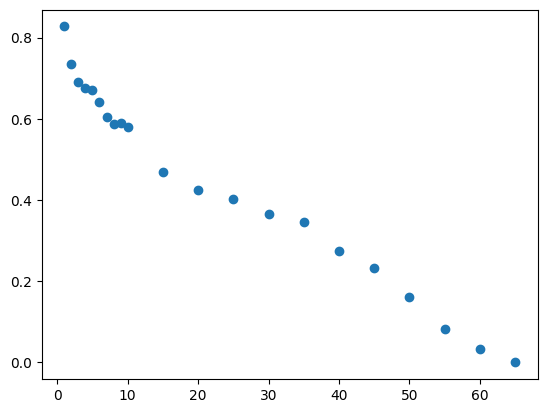

In [300]:
plt.plot(
    max_dim_vals,
    np.real(np.array(mpo_unitarity_scores)),
    'o'
)

So we need to crank up the virtual dimension for mpos? Yikes.

In [301]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0].take_slice(0, 'vL')
    dim = get_physical_dim(w, p_label='p')
    w2 = mpo2_tensors[0].take_slice(0, 'vL')

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        t /= dim

    e = t[0,0]

    return e

Define similar function to the above generalising $\textrm{Tr}(U^\dagger U U^\dagger U)$?

Define a similar function for arbitrary frobenius difference? Could be useful when approximating products of near-unitaries.

In [302]:
def frobenius_unitary_difference(
    mpo_tensors, unitary_tensors, mpo_frobenius_norm=None):

    if mpo_frobenius_norm is None:
        mpo_frobenius_norm = mpo_frobenius_inner_product(mpo_tensors)
    inner_product = mpo_frobenius_inner_product(mpo_tensors, unitary_tensors)

    return 1 - 2*inner_product.real + mpo_frobenius_norm

In [303]:
def frob_inner_product_tensors_against_mpo(mpo_tensors, mpo):
    t = mpo
    p_leg = 'p0'
    p_leg_c = 'p0*'
    w = (
        mpo_tensors[0]
        .replace_labels(['p', 'p*'], [p_leg, p_leg_c])
        .take_slice(0, 'vL')
    )
    t = npc.tensordot(t, w.conj(), [[p_leg, p_leg_c], [p_leg_c, p_leg]])

    
    dim = get_physical_dim(w, p_label=p_leg)
    t /= dim

    for i, w in enumerate(mpo_tensors[1:], start=1):
        p_leg = f'p{i}'
        p_leg_c = f'p{i}*'
        w = w.replace_labels(['p', 'p*'], [p_leg, p_leg_c])
        t = npc.tensordot(
            t,
            w.conj(),
            [[p_leg, p_leg_c, 'vR*'], [p_leg_c, p_leg, 'vL*']]
        )

        dim = get_physical_dim(w, p_label=p_leg)
        t /= dim

    e = t[0]

    return e

In [304]:
def split_u_error(mpo_tensors, u):
    mpo_frobenius_norm = mpo_frobenius_inner_product(mpo_tensors)

    u_hc_mpo_frob_inner_product = frob_inner_product_tensors_against_mpo(
        mpo_tensors, u
    )

    return 1 - 2*u_hc_mpo_frob_inner_product.real + mpo_frobenius_norm
    #return (u_hc_mpo_frob_inner_product.real, mpo_frobenius_norm)

In [305]:
test_mpo

<npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>

In [306]:
test_mpo_tensors_by_max_virtual_dim[0]

[<npc.Array shape=(1, 2, 2, 1) labels=['vL', 'p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 1, 1) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(1, 1, 2, 2) labels=['vR', 'vL', 'p', 'p*']>]

In [307]:
split_u_error(
    test_mpo_tensors_by_max_virtual_dim[0],
    test_mpo.split_legs()
)

(0.8885189946277328+0j)

In [308]:
split_u_errors = [
    split_u_error(ws, test_mpo.split_legs())
    for ws in test_mpo_tensors_by_max_virtual_dim
]

In [309]:
split_u_errors

[(0.8885189946277328+0j),
 (0.8096546657278086+0j),
 (0.75406552820741+0j),
 (0.7637713928152461+0j),
 (0.7546762274560459+0j),
 (0.7311546398277045+0j),
 (0.7109898489517943+0j),
 (0.6911763734917784+0j),
 (0.6925044920697908+0j),
 (0.6846914768863364+0j),
 (0.5606094032178519+0j),
 (0.46338524568633+0j),
 (0.3993559938667841+0j),
 (0.3152527475128488+0j),
 (0.24904212222971012+0j),
 (0.18064629165530377+0j),
 (0.14280044736811015+0j),
 (0.09211655720130851+0j),
 (0.044541152871643286+0j),
 (0.017663622720607508+0j),
 (-4.440892098500626e-16+0j)]

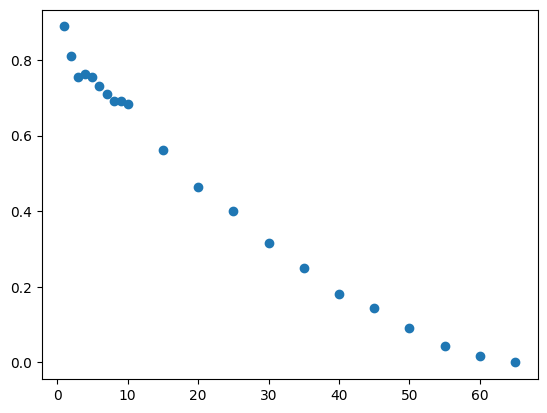

In [310]:
plt.plot(
    max_dim_vals,
    np.real(np.array(split_u_errors)),
    'o'
)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_8478/3348248756.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


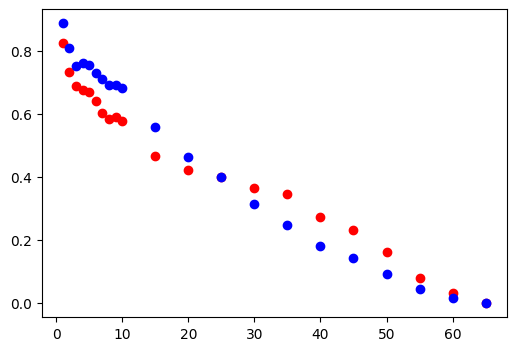

In [311]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(
    max_dim_vals,
    np.real(np.array(mpo_unitarity_scores)),
    'ro'
)

ax.plot(
    max_dim_vals,
    np.real(np.array(split_u_errors)),
    'bo'
)

fig.show()

In [312]:
split_u_squared_norm = [
    mpo_frobenius_inner_product(ws)
    for ws in test_mpo_tensors_by_max_virtual_dim
]

In [313]:
split_u_squared_norm

[(0.11148100537226725+0j),
 (0.18033813261687412+0j),
 (0.20631995397945463+0j),
 (0.21218603254157137+0j),
 (0.2131350092484954+0j),
 (0.24343601019575356+0j),
 (0.2680614538950657+0j),
 (0.2822848557970755+0j),
 (0.285567619544026+0j),
 (0.29690487523526177+0j),
 (0.43494760084482714+0j),
 (0.5367371493675764+0j),
 (0.6004331802776226+0j),
 (0.6877566898294851+0j),
 (0.7525165595003029+0j),
 (0.8201271858046175+0j),
 (0.8573303646794173+0j),
 (0.9072621372543259+0j),
 (0.9549586420919447+0j),
 (0.9822561022148306+0j),
 (0.9999999999999991+0j)]

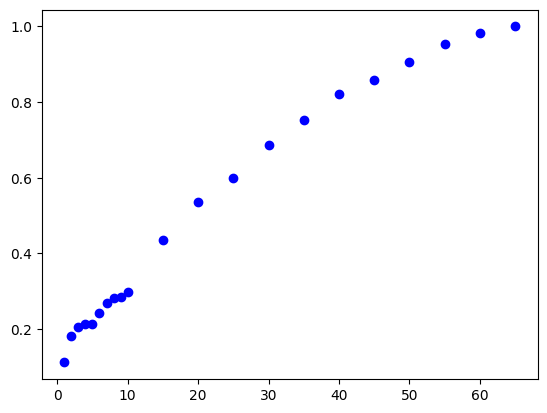

In [316]:
plt.plot(
    max_dim_vals,
    np.real(np.array(split_u_squared_norm)),
    'bo'
)

## Schmidt value normalisation

In [184]:
test_mpo

<npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>

In [185]:
npc.tensordot(
    test_mpo,
    test_mpo.conj(),
    [
        ['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)'],
        ['(p0*.p1*.p2*.p3*.p4*.p5*.p6*)', '(p0.p1.p2.p3.p4.p5.p6)']
    ]
)

(128.00000000000003+0j)

In [189]:
split_test_mpo = (
    test_mpo
    .split_legs()
    .combine_legs([
        ['p0', 'p1', 'p2', 'p3', 'p0*', 'p1*', 'p2*', 'p3*'],
        ['p4', 'p5', 'p6', 'p4*', 'p5*', 'p6*']
    ])
)

In [190]:
split_test_mpo

<npc.Array shape=(256, 64) labels=['(p0.p1.p2.p3.p0*.p1*.p2*.p3*)', '(p4.p5.p6.p4*.p5*.p6*)']>

In [191]:
U, S, VH = npc.svd(split_test_mpo)

In [192]:
S

array([4.30165611, 4.07442239, 2.86883116, 2.58150601, 2.35693369,
       2.16555361, 1.9046894 , 1.89179977, 1.79122453, 1.73173144,
       1.69298712, 1.63556623, 1.61056886, 1.55030566, 1.52434678,
       1.51093029, 1.46306624, 1.45622646, 1.41063529, 1.33150823,
       1.29033194, 1.25730773, 1.24244477, 1.20618016, 1.17079204,
       1.15359621, 1.13548117, 1.10407079, 1.08618833, 1.05999285,
       1.04038045, 1.00614054, 0.98955043, 0.95830412, 0.94666763,
       0.9120003 , 0.90711186, 0.86493545, 0.85917027, 0.84742021,
       0.80888873, 0.80514503, 0.78570842, 0.77296846, 0.75928405,
       0.72163339, 0.69484975, 0.67542963, 0.66444679, 0.63124617,
       0.60312943, 0.58930108, 0.57396738, 0.54767409, 0.53323575,
       0.51402761, 0.49906663, 0.48270007, 0.45664115, 0.4193766 ,
       0.4105994 , 0.3605691 , 0.33755624, 0.32526694])

In [193]:
np.sum(S**2)

127.99999999999994

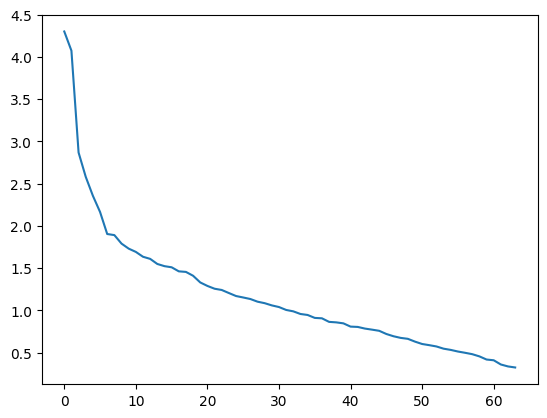

In [194]:
plt.plot(S)

So we do want to normalise. But how to deal with the big numbers?

## Redo with re-normalization

In [196]:
from operator import mul

In [205]:
def get_leg_dim(t, leg_label):
    return t.get_leg(leg_label).get_block_sizes()[0]

In [357]:
def split_combined_u_normalised(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = u.split_legs()
    num_sites = t.ndim //2
    
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    #total_dim = reduce(mul, (get_leg_dim(u, p) for p in p_leg_labels))

    p_leg_labels_hc = [l+'*' for l in p_leg_labels]
    out_ws = list()

    for i, (ll, ll_hc) in enumerate(zip(p_leg_labels[:-1], p_leg_labels_hc[:-1])):
        tail_legs = p_leg_labels[(i+1):]
        tail_legs_hc = p_leg_labels_hc[(i+1):]

        left_leg_labels = [ll, ll_hc]
        if 'vL' in t.get_leg_labels():
            left_leg_labels.append('vL')
    
        t = t.combine_legs([left_leg_labels, [*tail_legs, *tail_legs_hc]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=False
        )

        U.iscale_axis(S, axis='vR')

        wl = U.split_legs().replace_labels([ll, ll_hc], ['p', 'p*'])
        #wl.itranspose(['p', 'p*'])
        out_ws.append(wl)

        t = VH.split_legs()

    wl = t.replace_labels(
        [p_leg_labels[-1], p_leg_labels_hc[-1]],
        ['p', 'p*']
    )
    #wl.itranspose(['p', 'p*'])
    out_ws.append(wl)

    out_ws[0] = (
        out_ws[0]
        .add_leg(left_trivial_leg_charge, 0, label='vL')
    )
    
    out_ws[-1] = (
        out_ws[-1]
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    norm = mpo_frobenius_inner_product(out_ws)  
    scale_factor = np.power(norm, 1/(2*num_sites))

    for i, w in enumerate(out_ws):
        out_ws[i] /= scale_factor

    return out_ws

In [358]:
max_dim_vals

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]

To do: Step through and check singular values.

In [359]:
test_mpo_tensors_by_max_virtual_dim = [
    split_combined_u_normalised(test_mpo.split_legs(), i)
    for i in max_dim_vals
]

In [360]:
mpo_unitarity_scores = [
    mpo_unitarity_score(ws)
    for ws in test_mpo_tensors_by_max_virtual_dim
]

In [361]:
mpo_unitarity_scores

[(3.037990121181784+0j),
 (1.9034744399849708+0j),
 (1.4125751374218751+0j),
 (1.2244231097249436+0j),
 (1.1214284133628372+0j),
 (1.155071724486489+0j),
 (0.9619683955371237+0j),
 (0.8886395786227466+0j),
 (0.9718288647404749+0j),
 (0.954996337851322+0j),
 (0.7909101232321676+0j),
 (0.7252607623715532+0j),
 (0.6712941274385429+0j),
 (0.5668194329014928+0j),
 (0.5018888076156487+0j),
 (0.3592329228604252+0j),
 (0.29004617297272106+0j),
 (0.1857361728525211+0j),
 (0.08686871496243165+0j),
 (0.034934704771480085+0j),
 0j]

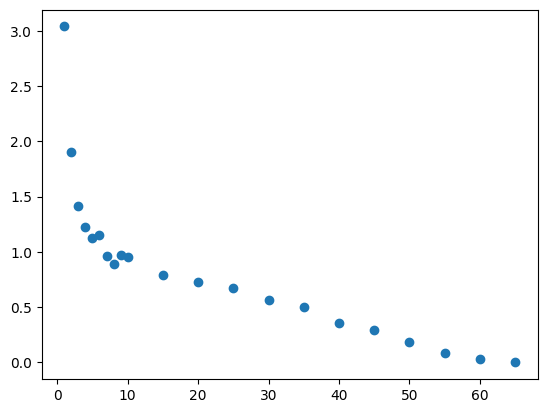

In [362]:
plt.plot(
    max_dim_vals,
    np.real(np.array(mpo_unitarity_scores)),
    'o'
)

In [363]:
split_u_errors = [
    split_u_error(ws, test_mpo.split_legs())
    for ws in test_mpo_tensors_by_max_virtual_dim
]

In [364]:
split_u_errors

[(1.3322245725626993+0j),
 (1.1271101730727486+0j),
 (1.0043373647500722+0j),
 (1.0265326572448095+0j),
 (1.0069459201630484+0j),
 (0.9617160232524862+0j),
 (0.9240456696479611+0j),
 (0.8874401022878458+0j),
 (0.8901955987342992+0j),
 (0.8764454430166722+0j),
 (0.6742519951380759+0j),
 (0.5349201232816413+0j),
 (0.44997545227223723+0j),
 (0.34500689474764745+0j),
 (0.2668425519974902+0j),
 (0.18963662132156323+0j),
 (0.14829855795083757+0j),
 (0.09434153199653394+0j),
 (0.04504842757688232+0j),
 (0.01774231854734265+0j),
 (-4.440892098500626e-16+0j)]

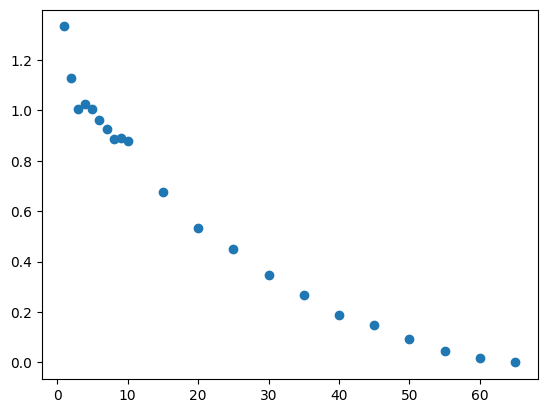

In [365]:
plt.plot(
    max_dim_vals,
    np.real(np.array(split_u_errors)),
    'o'
)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_8478/3348248756.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


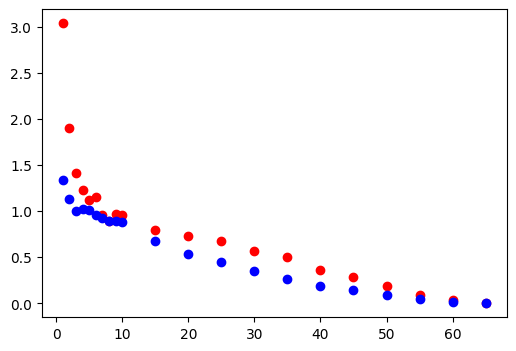

In [366]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(
    max_dim_vals,
    np.real(np.array(mpo_unitarity_scores)),
    'ro'
)

ax.plot(
    max_dim_vals,
    np.real(np.array(split_u_errors)),
    'bo'
)

fig.show()

In [367]:
split_u_squared_norm = [
    mpo_frobenius_inner_product(ws)
    for ws in test_mpo_tensors_by_max_virtual_dim
]

In [368]:
split_u_squared_norm

[(0.9999999999999993+0j),
 (1.0000000000000016+0j),
 (0.9999999999999987+0j),
 (0.9999999999999987+0j),
 (1.0000000000000009+0j),
 (1.0000000000000009+0j),
 (1.0000000000000004+0j),
 (0.9999999999999982+0j),
 (0.9999999999999994+0j),
 (0.9999999999999984+0j),
 (1+0j),
 (0.999999999999999+0j),
 (1+0j),
 (1.0000000000000018+0j),
 (0.9999999999999993+0j),
 (1.0000000000000016+0j),
 (1.0000000000000002+0j),
 (1.0000000000000004+0j),
 (1.0000000000000018+0j),
 (1.000000000000001+0j),
 (1.0000000000000022+0j)]

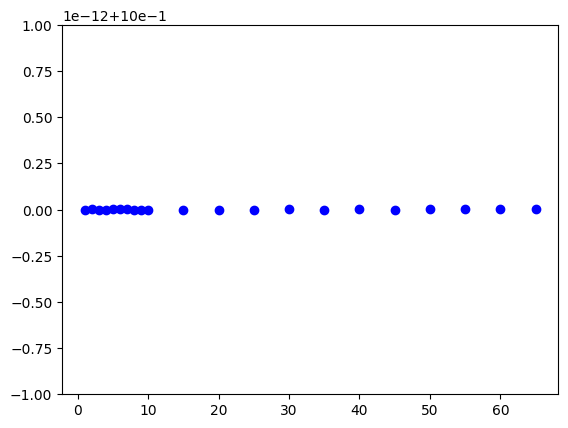

In [369]:
plt.plot(
    max_dim_vals,
    np.real(np.array(split_u_squared_norm)),
    'bo'
)

So re-normalising does not help much. Would not affect the SPT phase at the end of the calculation anyway.

# Conclusions

* Seems like for unitaries defined on many sites a high bond dimension is required or a better optimisation scheme?

* The unitarity and approximation scores seem strongly related. Enough to get a good approximation?